In [386]:
# импортируем необходимые библиотеки

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce #кодирование признаков
import re # для использования регулярных выражений

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# для вычисления расстояния
from geopy.distance import geodesic as GD

# для нормализации, стандартизации
from sklearn import preprocessing
from scipy.stats import normaltest

# для отбора признаков
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# загружаем библиотеку для разделения датасета:
from sklearn.model_selection import train_test_split

# импортируем необходимые библиотеки для создания модели
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# **Краткое описание проекта**

Мы участвуем в соревновании, в котором мы строим модель, способную предсказать рейтинг отеля. Нам требуется построить модель, при помощи которой компания Booking сможет отличать отели, накручивающие рейтинг, от отелей с реальным рейтингом.

Наша цель в данном проекте изменить baseline и построить модель, которая будет работать лучше базовой модели.

In [387]:
# фиксируем RANDOM_SEED для воспроизводимости экспертиментов
RANDOM_SEED = 42

In [388]:
# также зафиксируем версию пакетов для вопроизводимости кода
!pip freeze > requirements.txt

In [389]:
# подгрузим данные из соревнования
data = pd.read_csv('data/hotels.csv')
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


# **Знакомство с данными**

In [390]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

**Признаки**

hotel_address - адрес отеля

review_date - дата, когда рецензент разместил соответствующий отзыв

average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год

hotel_name - название отеля

reviewer_nationality - национальность рецензента

negative_review - отрицательный отзыв, который рецензент дал отелю

review_total_negative_word_counts - общее количество слов в отрицательном отзыв

positive_review - положительный отзыв, который рецензент дал отелю

review_total_positive_word_counts - общее количество слов в положительном отзыве

reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта

total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом

total_number_of_reviews - общее количество действительных отзывов об отеле

tags - теги, которые рецензент дал отелю

days_since_review - продолжительность между датой проверки и датой очистки

additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки

lat - широта отеля

lng - долгота отеля

In [391]:
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


# **Исследование данных**

In [392]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


In [393]:
data.describe(include='object')

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386803,386803,386803,386803,386803,386803,386803,386803
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1911,3587,184033,95907,26885,3853,1911


array([[<AxesSubplot: title={'center': 'additional_number_of_scoring'}>,
        <AxesSubplot: title={'center': 'average_score'}>,
        <AxesSubplot: title={'center': 'review_total_negative_word_counts'}>],
       [<AxesSubplot: title={'center': 'total_number_of_reviews'}>,
        <AxesSubplot: title={'center': 'review_total_positive_word_counts'}>,
        <AxesSubplot: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot: title={'center': 'reviewer_score'}>,
        <AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': 'lng'}>]], dtype=object)

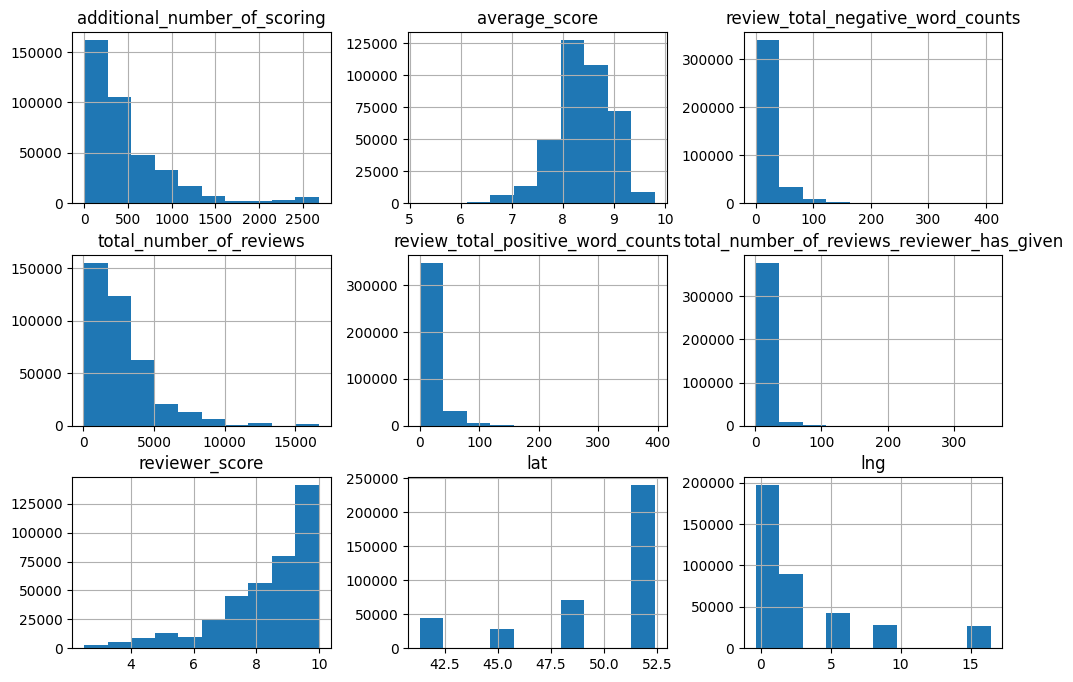

In [394]:
data.hist(figsize=(12,8))

In [395]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             225
negative_review                               248828
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               311737
review_total_positive_word_counts                354
total_number_of_reviews_reviewer_has_given       194
reviewer_score                                    37
tags                                           47135
days_since_review                                731
lat                                             1473
lng                                             1473
dtype: int64

C:\Users\sergi\AppData\Local\Temp\ipykernel_6944\1414009637.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True)


<AxesSubplot: >

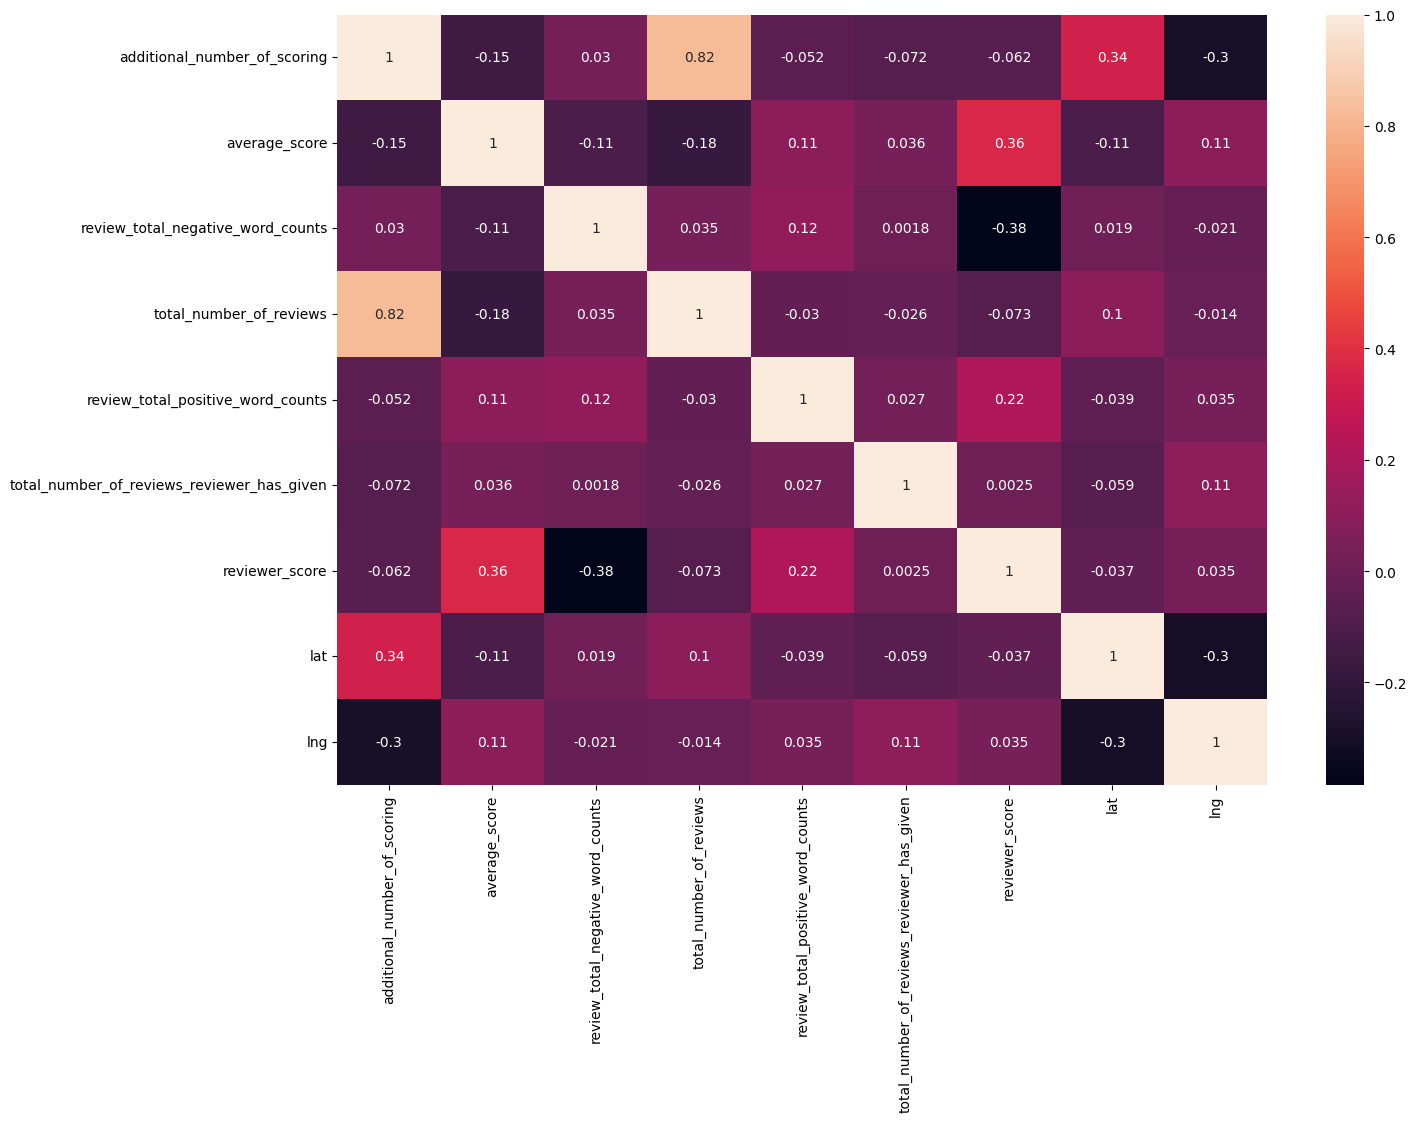

In [396]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(), annot=True)

Небольшое резюме по итогам исследования данных. Датасет содержит два признака, имеющих пропуски в данных - lat и lng. Кроме того, датасет содержит восемь признаков с данными типа object, которые будет необходимо преобразовать или удалить для дальнейшего обучения модели. 

Судя по графикам, числовые признаки распределены ненормально. Категориальные признаки содержат большое число уникальных значений. В дальнейшем потребуется либо сгруппировать данные признаки, либо использовать двоичное кодирование, либо удалить.

Признаки total_number_of_reviews и additional_number_of_scoring достаточно сильно скореллированы.

# **Подготовка данных**

**Работа с пропусками**

In [397]:
# проверим для скольких отелей у нас отсутсвуют данные об широте
data.groupby(data['lat'].isnull()).nunique()


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
lat,,,,,,,,,,,,,,,,,
False,1476,479,731,34,1475,225,247272,402,1132,309744,353,193,37,46886,731,1472,1472
True,17,17,677,10,17,105,1691,131,17,2211,120,74,27,1083,677,0,0


In [398]:
# проверим для скольких отелей у нас отсутсвуют данные об долготе
data.groupby(data['lng'].isnull()).nunique()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
lng,,,,,,,,,,,,,,,,,
False,1476,479,731,34,1475,225,247272,402,1132,309744,353,193,37,46886,731,1472,1472
True,17,17,677,10,17,105,1691,131,17,2211,120,74,27,1083,677,0,0


Отсутствующие значения для признаков lat и lng присутствуют у 17 отелей из 1493. Заполнение данного поля модой или нулями не даст какого-либо эффекта, поскольку координаты отеля привязаны к его конкретному адресу. Заполнение пропусков по подобной схеме скорее может запутать нашу модель. Можно заполнить пропуски модой по конкретному району города, где расположен отель, но, поскольку пропуски содержатся в небольшом количестве наших данных, то полагаю более целесообразно будет удалить такие строки, содержащие отсутствующие значения.

In [399]:
# создадим отдельный датафрейм, который содержит пропущенные значения
is_null = data.isnull()
row_with_null = is_null.any(axis=1)
data_with_null = data[row_with_null]

In [400]:
# посмотрим на адреса отелей, у которых отсутствуют данные об их координатах
data_with_null.hotel_address.unique()

array(['Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
       '23 Rue Damr mont 18th arr 75018 Paris France',
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
       'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
       '4 rue de la P pini re 8th arr 75008 Paris France',
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
       'Bail n 4 6 Eixample 08010 Barcelona Spain',
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
       '20 Rue De La Ga t 14th arr 75014 Paris France',
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
       'Sep lveda 180 Eixample 08011 Barcelona Spain',
       'Pau Clar s 122 Eixample 08009 Barcelona Spain',
       'Josefst dter Stra e 22 08 Jos

Теперь мы видим, что в нашем наборе данных есть несколько отелей в Австрии, Франции и Испании, у которых отсутствует информация о их географических координатах. Далее мы будем выделять в отдельный признак данные о городе и стране, где расположены отели. Заполним пропуски медианным значением отдельно по каждому городу.

**Создание новых признаков**

Из признака с адресом отеля создадим новые признаки, которые будут содержать информацию о стране и городе, где расположен отель.

In [401]:
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              3587
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     3206
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     3095
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    2688
7 Pepys Street City of London London EC3N 4AF United Kingdom                      2379
                                                                                  ... 
Via Palmanova 153 20132 Milan Italy                                                  7
40 Rue Rene Boulanger 10th arr 75010 Paris France                                    7
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                              6
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              6
13 Rue Fran ois Ory 92120 Paris France                                               5
Name: hotel_address, Length: 1493, dtype: i

Как мы видим из содержания поля с адресом отеля, страна отеля всегда стоит на последнем месте. Для всех стран за исключением Великобритании перед названием страны идет название города. Для Великобритании название города идет чуть раньше перед почтовым кодом.

Также мы видим, что отображение почтового кода отличается в зависимости от страны для Голландии и Великобритании он состоит из двух обозначений. При этом согласно информации из открытых источников, для нас будет иметь значение именно первое значение, поскольку оно привязано к конкретному району города. Для остальных странн почтовый код состоит из одного набора цифр.

In [402]:
# напишем функцию, которая позволит нам извлечь название страны из адреса отеля
def get_hotel_country(address):
    counrty = address.split()[-1]
    if counrty == 'Kingdom':
        return 'United Kingdom'
    else:
        return counrty

data['hotel_country'] = data['hotel_address'].apply(get_hotel_country)

In [403]:
# напишем функцию, которая позволит нам извлечь название страны из адреса отеля
def get_hotel_city(address):
    counrty = address.split()[-1]
    if counrty == 'Kingdom':
        return address.split()[-5]
    else:
        return address.split()[-2]

data['hotel_city'] = data['hotel_address'].apply(get_hotel_city)

In [404]:
# напишем функцию, которая позволит нам извлечь номер почтового кода из адреса отеля
def get_zip_code(address):
    counrty = address.split()[-1]
    if counrty == 'Kingdom' or counrty ==  'Netherlands':
        return address.split()[-4]
    else:
        return address.split()[-3]

data['hotel_zip'] = data['hotel_address'].apply(get_zip_code)

Теперь прежде чем переходить к дальнейшему проектированию признаков, вспомним, что у нас в данных были пропущенные значения, которые мы хотели заполнить, получив информацию о городах.

In [405]:
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
hotel_country                                    0
hotel_city                                       0
hotel_zip                      

In [406]:
# заполняем пропуски медианным значением по каждому городу
paris_median = {'lat': 48.866805, 'lng': 2.328075}
mask_paris = data.hotel_city == 'Paris'
data.loc[mask_paris] = data.loc[mask_paris].fillna(paris_median)

barcelona_median = {'lat': 41.388024, 'lng': 2.169670}
mask_barc = data.hotel_city == 'Barcelona'
data.loc[mask_barc] = data.loc[mask_barc].fillna(barcelona_median)

vienna_median = {'lat': 48.203745, 'lng': 16.367288}
mask_vienna = data.hotel_city == 'Vienna'
data.loc[mask_vienna] = data.loc[mask_vienna].fillna(vienna_median)

In [407]:
# проверяем на наличие пропусков и видим, что пропусков больше нет
data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
hotel_country                                 0
hotel_city                                    0
hotel_zip                                     0
dtype: int64

Создадим признак, который будет показывать, что отзыв оставлен гостем из той же страны, где расположен отель. Предположим, что это может влиять на итоговую оценку.

In [408]:
# сначала нам необходимо убрать лишние пробелы в признаке, содержащем данные о национальности постояльца
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())
data['local_review'] = np.where(data['reviewer_nationality'] == data['hotel_country'], 1, 0)

Теперь, когда у нас есть признак с информацией о городах, где расположены отели, вычислим расстояние от местоположения отеля до центра города, и создадим новый признак, содержащий данную информацию.

In [409]:
# составим списки с координатами центров городов, где находятся отели, и названиями колонок для датафрейма
centers = [['London', 51.5085300, -0.1257400], ['Paris', 48.8534100, 2.3488000],
           ['Vienna', 48.2084900, 16.3720800],['Amsterdam', 52.3740300, 4.8896900],
           ['Barcelona', 41.3887900, 2.1589900], ['Milan', 45.4642700, 9.1895100],
          ]
columns= ['hotel_city', 'center_lat', 'center_lng']
# создадим датафрейм с координатами городских центров
city_centers = pd.DataFrame(centers, columns=columns).set_index('hotel_city')
# создадим отдельный датафрейм с названиями отелей и их координатами и добавим в него информацию о координатах городских центров
hotels_names = data[['hotel_address', 'hotel_city', 'lat', 'lng']].drop_duplicates()
hotels_names = hotels_names.merge(city_centers, on='hotel_city', how='left', sort=False)

# напишем функцию, которая будет высчитывать расстояние до центра города
def get_distance(center_lng, center_lat, lng, lat):
   return GD([center_lng, center_lat], [lng, lat]).km

# применим данную функцию к датафрейму с отелями для создания нового признака
hotels_names['center_distance'] = hotels_names.apply(
    lambda x: get_distance(x['center_lng'], x['center_lat'], x['lng'], x['lat']), axis=1)
# удалим лишние признаки, чтобы у нас остались только название отеля и расстояние до центра
hotels_names.drop(['hotel_city', 'lat', 'lng', 'center_lat', 'center_lng'], axis=1, inplace=True)
# объединим полученные данные с основным датасетом
data = data.merge(hotels_names, on='hotel_address', how='left', sort=False)

In [410]:
# теперь можно удалить старые признаки с адресом и координатами из основного датасета
data.drop(['hotel_address', 'lat', 'lng'], axis=1, inplace=True)

Cоздаем признак, определяющий принадлежность отеля к сети отелей.

In [411]:
# Составляем список c наименованиями сетей отелей
large_hotel_chains = ['Ibis', 'Best Western', 'Holiday Inn', 'Mercure', 'Premier Inn',
                'Novotel', 'Hilton', 'NH', 'Travelodge', 'Four Seasons', 'Hyatt',
                'InterContinental', 'Kempinski', 'Lotte', 'Marriott', 'Ritz',
                'Millennium', 'Copthorne', 'Radisson', 'Wyndham', 'Accor', 'Whitbread',
                'Melia', 'Louvre', 'TUI', 'Carlson', 'Motel One'
                ]

# Пишем функцию, которая проверяет наличие в наименовании отеля названия сети
def if_chain (hotel):
    for h in large_hotel_chains:
        if h.lower() in hotel.lower():
            return 1
    return 0

data['chain_hotel'] = data['hotel_name'].apply(if_chain)

Создаем новые признаки, которые содержат информацию о месяце и годе, в котором оставлен отзыв.

In [412]:
# создаем новые признаки с месяцем и годом отзыва
data['review_date'] = pd.to_datetime(data['review_date'])
data['review_month'] = data['review_date'].dt.month
data['review_year'] = data['review_date'].dt.year


In [413]:
# теперь удалим признак с датой отзыва, поскольку мы разбили его на несколько новых признаков
data.drop(['review_date'], axis=1, inplace=True)

Создаем новые самостоятельные признаки из признака с тегами.

In [414]:
# посмотрим на содержание признака с тегами
data['tags'].value_counts()

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                              3853
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                     3673
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                     3274
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                       2964
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                                                             2454
                                                                                                                                                      

Как мы видим, система тегов построена таким образом, что по ряду ключевых слов мы можем создать отдельные признаки, которые будут характеризовать проживание рецензента.

In [415]:
# признак с информацией о типе поездки
trip_reg = 'Leisure|Business'
data['trip_type'] = data['tags'].str.findall(trip_reg).str.get(0)
data['trip_type'] = data['trip_type'].fillna(data['trip_type'].mode()[0])

# признак с информацией о типе постояльца
traveler_reg = 'Couple|Solo traveler|Group|Family with young children|Family with older children|Travelers with friends'
data['traveler_type'] = data['tags'].str.findall(traveler_reg).str.get(0)

# признак с информацией о типе комнаты
room_reg = '[a-zA-Z\s]+Room|\d\srooms|[a-zA-Z\s]+Suite|[a-zA-Z\s]+Appartment'
data['room_type'] = data['tags'].str.findall(room_reg).str.get(0)
data['room_type'] = data['room_type'].fillna('other')

# признак с информацией о количестве ночей
nights_reg = 'Stayed\s([\d]*)'
data['nights_amount'] = data['tags'].str.findall(nights_reg).str.get(0)
data['nights_amount'] = data['nights_amount'].fillna(data['nights_amount'].mode()[0])
data['nights_amount'] = data['nights_amount'].astype('int64')

# признак с информацией о способе бронирования
data['mobile_submission'] = data['tags'].str.findall('Submitted from a mobile device').str.get(0)

In [416]:
# также удалим признак с тегами, поскольку после его разбивки на новые признаки мы его больше использовать не будем
data.drop(['tags'], axis=1, inplace=True)

**Кодирование и преобразование признаков**

Перед кодированием признаков еще раз взглянем на нечисловые признаки.

In [417]:
data.describe(include='object')

,hotel_name,reviewer_nationality,negative_review,positive_review,days_since_review,hotel_country,hotel_city,hotel_zip,trip_type,traveler_type,room_type,mobile_submission
count,386803,386803,386803,386803,386803,386803,386803,386803,386803,386803,386803,230778
unique,1492,225,248828,311737,731,6,6,239,2,6,838,1
top,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,1 days,United Kingdom,London,W2,Leisure,Couple,Double Room,Submitted from a mobile device
freq,3587,184033,95907,26885,1911,196774,196774,24878,324796,189212,34564,230778


Признак с названием отеля содержит слишком много уникальных значений. Его кодирование скорее навредит работе модели.

Кроме того, можно предположить, что он и содержательно не будет иметь ценности для построения модели, поскольку отражает не столько какие-то общие закономерности, а имеет отношение непосредственно к каждому уникальному отелю.

In [418]:
# удалим признак с названием отеля
data.drop(['hotel_name'], axis=1, inplace=True)

Признаки с информацией о негативных и позитивных отзывах также содержат много уникальных значений. Попробуем поработать с ними и преобразовать их таким образом, чтобы они могли быть восприняты моделью.

In [419]:
# посмотрим, какие значения содержит признак с негативные отзывами
data['negative_review'].value_counts()

No Negative                                                                                                                                                                                                                                                                                                                                                                    95907
 Nothing                                                                                                                                                                                                                                                                                                                                                                       10737
 Nothing                                                                                                                                                                                                                                                      

In [420]:
# посмотрим, какие значения содержит признак с позитивными отзывами
data['positive_review'].value_counts()

No Positive                                                                                                                             26885
 Location                                                                                                                                6833
 Everything                                                                                                                              1697
 location                                                                                                                                1251
 Nothing                                                                                                                                  931
                                                                                                                                        ...  
 Motel not hotel                                                                                                                            1
 Conve

Как мы видим, из содержания данных признаков зачастую положительный или отрицательный отзыв по факту по содержанию являются своей противоположностью. Попробуем отделить реально положительные/отрицательные отзывы от ложноположительных/отрицательных отзывов.

In [421]:
# пишем функции, которые позволяют определить оставил ли рецензент негативные или позитивный отзыв отелю
def negative_reviews(review):
    non_negative = ['no negative', ' nothing', ' none', ' na', ' n a', ' ']
    if review.lower() in non_negative:
        return 0
    return 1

def positive_reviews(review):
    non_positive = ['no positive', ' nothing', ' none', ' na', ' n a', ' ']
    if review.lower() in non_positive:
        return 0
    return 1

data['negative_review'] = data['negative_review'].apply(negative_reviews)
data['positive_review'] = data['positive_review'].apply(positive_reviews)

Также мы понимаем, что признак, показывающий количество дней, прошедших с момента размещения отзыва, должен быть числовым. Соответственно, нам требуется преобразовать его.

In [422]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0])
data['days_since_review'] = data['days_since_review'].astype('int64')

Построим несколько столбчатых диаграмм, чтобы посмотреть на то, как распределены оставшиеся нечисловые признаки, и как они соотносятся с целевым показателем.

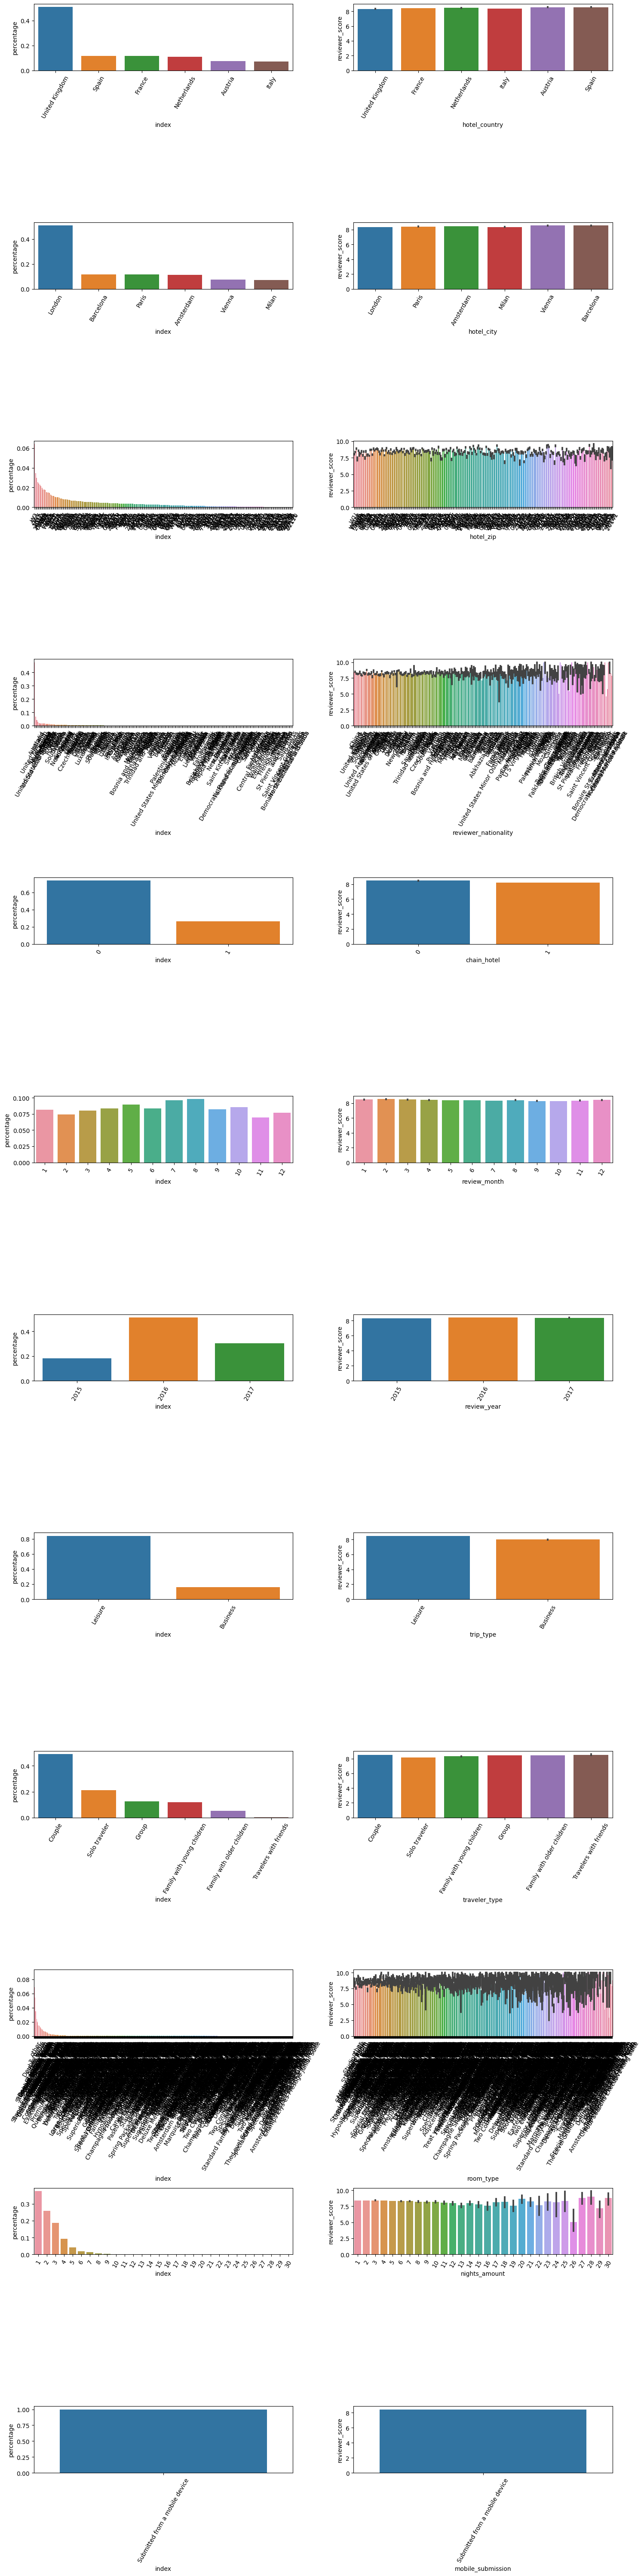

In [423]:
cat_features = ['hotel_country', 'hotel_city', 'hotel_zip', 'reviewer_nationality', 'chain_hotel', 'review_month','review_year',
                'trip_type', 'traveler_type', 'room_type', 'nights_amount', 
                'mobile_submission'
               ]
n = len(cat_features)

fig, axes = plt.subplots(n, 2, figsize=(15, 60)) # фигура+n*2 координатных плоскостей

# Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    # Строим количественную столбчатую диаграмму для изучения долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    # Строим столбчатую диаграмму средней оценки в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='reviewer_score', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

Из построенных графиков мы видим, что часть полученных признаков содержит слишком большое количество категорий. В дальнейшем будет целесообразно сгруппировать такие признаки. Кроме того, складывается ощущение, что полученные признаки не окажут решающего влияния на определение оценки, оставленной постояльцем отеля.

Особенно мне не понравился признак с почтовым кодом отеля. После более углубленного анализа почтовых кодов, мне показалось, что сгруппировать по этим данным отели по районам по всем представленным городам не получится. Однако, поскольку подавляющая часть наших отелей расположена в Лондоне, то попробуем сгруппировать данные по Лондону. Остальные попробуем обозначить просто как district.

In [424]:
# напишем функцию, которая будет находить данные о районе на основе почтового кода
def get_london_district(zip):
    """Данная функция при помощи регулярных выражений находит среди почтовых кодов отелей
    те, которые относятся к определенным районам Лондона и возвращает название соответствующего района.
    Если почтовый код не относится к Лондону, то функция возвращает district"""
    if re.search('^E\d+', zip):
        return 'Eastern'
    if re.search('^EC\d+', zip):
        return 'Eastern Central'
    if re.search('^N\d+', zip):
        return 'Northern'
    if re.search('^NW\d+', zip):
        return 'North Western'
    if re.search('^SE\d+', zip):
        return 'South Eastern'
    if re.search('^SW[1-9]{1}[1-9]{1}|SW20', zip):
        return 'Battersea'
    if re.search('^SW[0-9]{1}|^SW10', zip):
        return 'South Western'
    if re.search('^W1', zip):
        return 'Western'
    if re.search('^W[2-9]', zip):
        return 'Paddington'
    if re.search('^WC\d+', zip):
        return 'Western Central'
    if re.search('^HA\d+', zip):
        return 'Harrow'
    if re.search('^IG\d+', zip):
        return 'Ilford'
    else:
        return 'district'

    
data['hotel_zip'] = data['hotel_zip'].apply(get_london_district)

In [425]:
data['hotel_zip'].value_counts()

district           190029
Paddington          36154
South Western       33981
Western             30395
Western Central     23397
South Eastern       19595
Eastern Central     17573
Eastern             17070
North Western        9518
Harrow               4943
Battersea            1786
Northern             1782
Ilford                580
Name: hotel_zip, dtype: int64

In [426]:
# кодируем полученные данные
dummies_data = pd.get_dummies(data['hotel_zip'])
data = pd.concat([data, dummies_data], axis=1)
# удаляем первоначальный признак
data = data.drop(['hotel_zip'], axis=1)

Закодируем признак с национальностью рецензента. Как мы видели из графика и анализа данных выше, у нас в данных присутствует большое количество постояльцев с разными национальностями. Стоит подумать над тем, как сократить число значений данного признака.

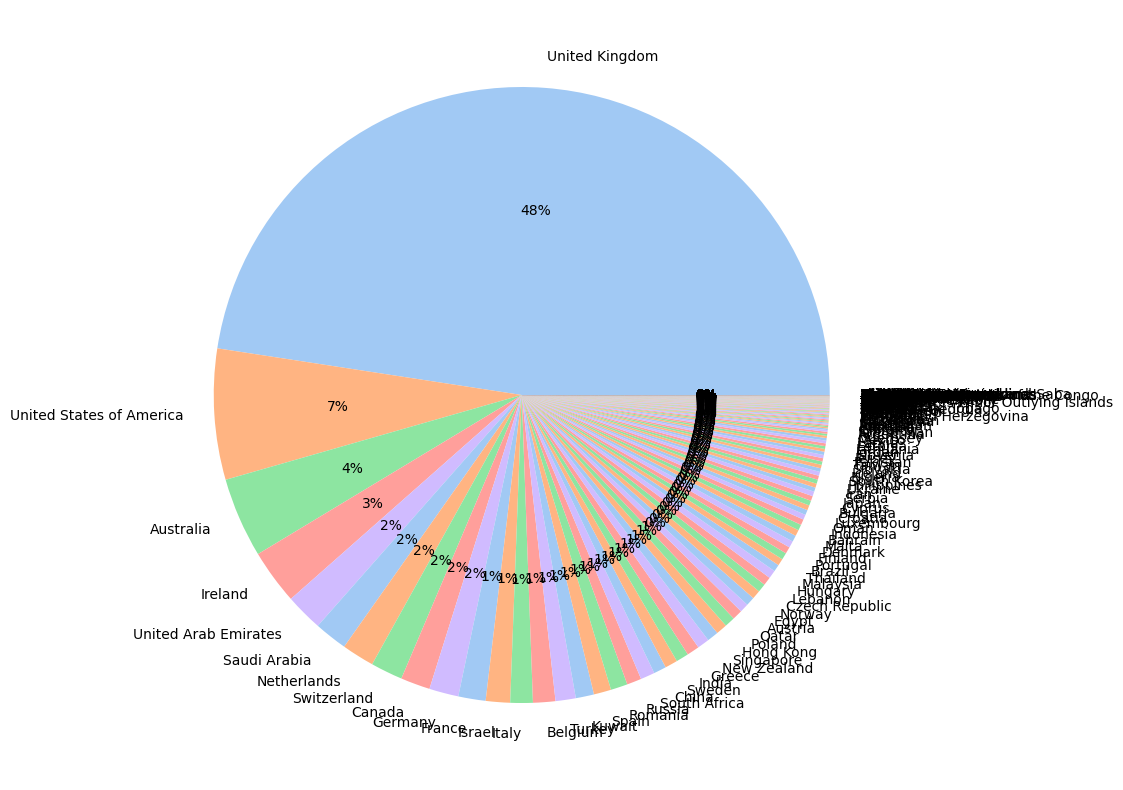

In [427]:
# прежде чем кодировать признак посмотрим на процентное соотношение данных
pie = data['reviewer_nationality'].value_counts()
keys = data['reviewer_nationality'].value_counts().index.tolist()
colors = sns.color_palette('pastel')[0:5]
plt.pie(pie, colors = colors, labels=keys, autopct='%.0f%%')
plt.show()

In [428]:
# оставим только три самые популярные национальности остальные обозначим как 'other_nationalities'
popular_countries = data['reviewer_nationality'].value_counts().nlargest(3)
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in popular_countries else 'other_nationalities')
# кодируем полученные данные
dummies_data = pd.get_dummies(data['reviewer_nationality'])
data = pd.concat([data, dummies_data], axis=1)
# удаляем первоначальный признак
data = data.drop(['reviewer_nationality'], axis=1)

Как мы видим из графика выше, подавляющее число гостей останавливается в отелях на период с 1 до 4 ночей. По этой причине сгруппируем остальные данные в единый признак long_stay.

In [429]:
# пишем функцию, которая сгруппирует данные по гостям, кто останавливался дольше чем на 4 ночи
def long_stay(nights):
    if nights <= 4:
        return f'{nights} nights'
    else:
        return 'long_stay'

data['nights_amount'] = data['nights_amount'].apply(long_stay)
# кодируем полученные данные
dummies_data = pd.get_dummies(data['nights_amount'])
data = pd.concat([data, dummies_data], axis=1)
# удаляем первоначальный признак
data = data.drop(['nights_amount'], axis=1)

Закодируем признак, содержащий информацию о типе комнаты.

In [430]:
#создаем функцию, которая группирует популярные типы комнат
def get_room_type(room):
    if 'Superior' in room or 'Deluxe' in room or 'King' in room or 'Queen' in room:
        return 'superior_or_deluxe_room'
    if 'Double' in room or 'Twin' in room:
        return 'double_or_twin_room'
    if 'Single' in room or 'Classic' in room:
        return 'single_room'
    if 'rooms' in room:
        return 'several_rooms'
    return 'other_room_type'

data['room_type'] = data['room_type'].apply(get_room_type)

# кодируем полученные данные
dummies_data = pd.get_dummies(data['room_type'])
data = pd.concat([data, dummies_data], axis=1)
# удаляем первоначальный признак
data = data.drop(['room_type'], axis=1)

Кодируем признаки с типом поездки, постояльца и способа бронирования

In [431]:
data = pd.get_dummies(data, prefix=['trip', 'traveler', 'booking'],
                        columns=['trip_type', 'traveler_type','mobile_submission']
                        )

Кодируем признаки с месяцем и годом бронирования. Предположим, что для месяцев и отзывов об отеле большее значение имеет сезонность, а не кокретный месяц. Поэтому объедим месяцу отзыва по сезонам.

In [432]:
# сгруппируем месяца по сезонам

def group_month(month):
    if month == 12 or month == 1 or month == 2:
        return 'winter_month'
    if month == 3 or month == 4 or month == 5:
        return 'spring_month'
    if month == 6 or month == 7 or month == 8:
        return 'summer_month'
    return 'autumn_month'

data['review_month'] = data['review_month'].apply(group_month)
# кодируем полученные данные
dummies_data = pd.get_dummies(data[['review_month', 'review_year']])
data = pd.concat([data, dummies_data], axis=1)

# удаляем первоначальные признаки
data = data.drop(['review_month', 'review_year'], axis=1)

Кодируем признак с городом, в котором расположен отель. Поскольку в наших данных одна страна представлена одним городом, то очевидно, что данные признаки дублируют друг друга. По этой причине удалим признак, содержащий информацию о стране отеля.

In [433]:
# кодируем полученные данные
dummies_data = pd.get_dummies(data['hotel_city'])
data = pd.concat([data, dummies_data], axis=1)

# удаляем первоначальные признаки
data = data.drop(['hotel_city', 'hotel_country'], axis=1)

Посмотрим еще раз на наши данные и увидим, что в них не осталось признаков с типом данных object.

In [434]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 0 to 386802
Data columns (total 59 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   negative_review                             386803 non-null  int64  
 3   review_total_negative_word_counts           386803 non-null  int64  
 4   total_number_of_reviews                     386803 non-null  int64  
 5   positive_review                             386803 non-null  int64  
 6   review_total_positive_word_counts           386803 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 8   reviewer_score                              386803 non-null  float64
 9   days_since_review                           386803 non-null  int64  
 

# Отбор признаков

In [435]:
hotels = data.copy()

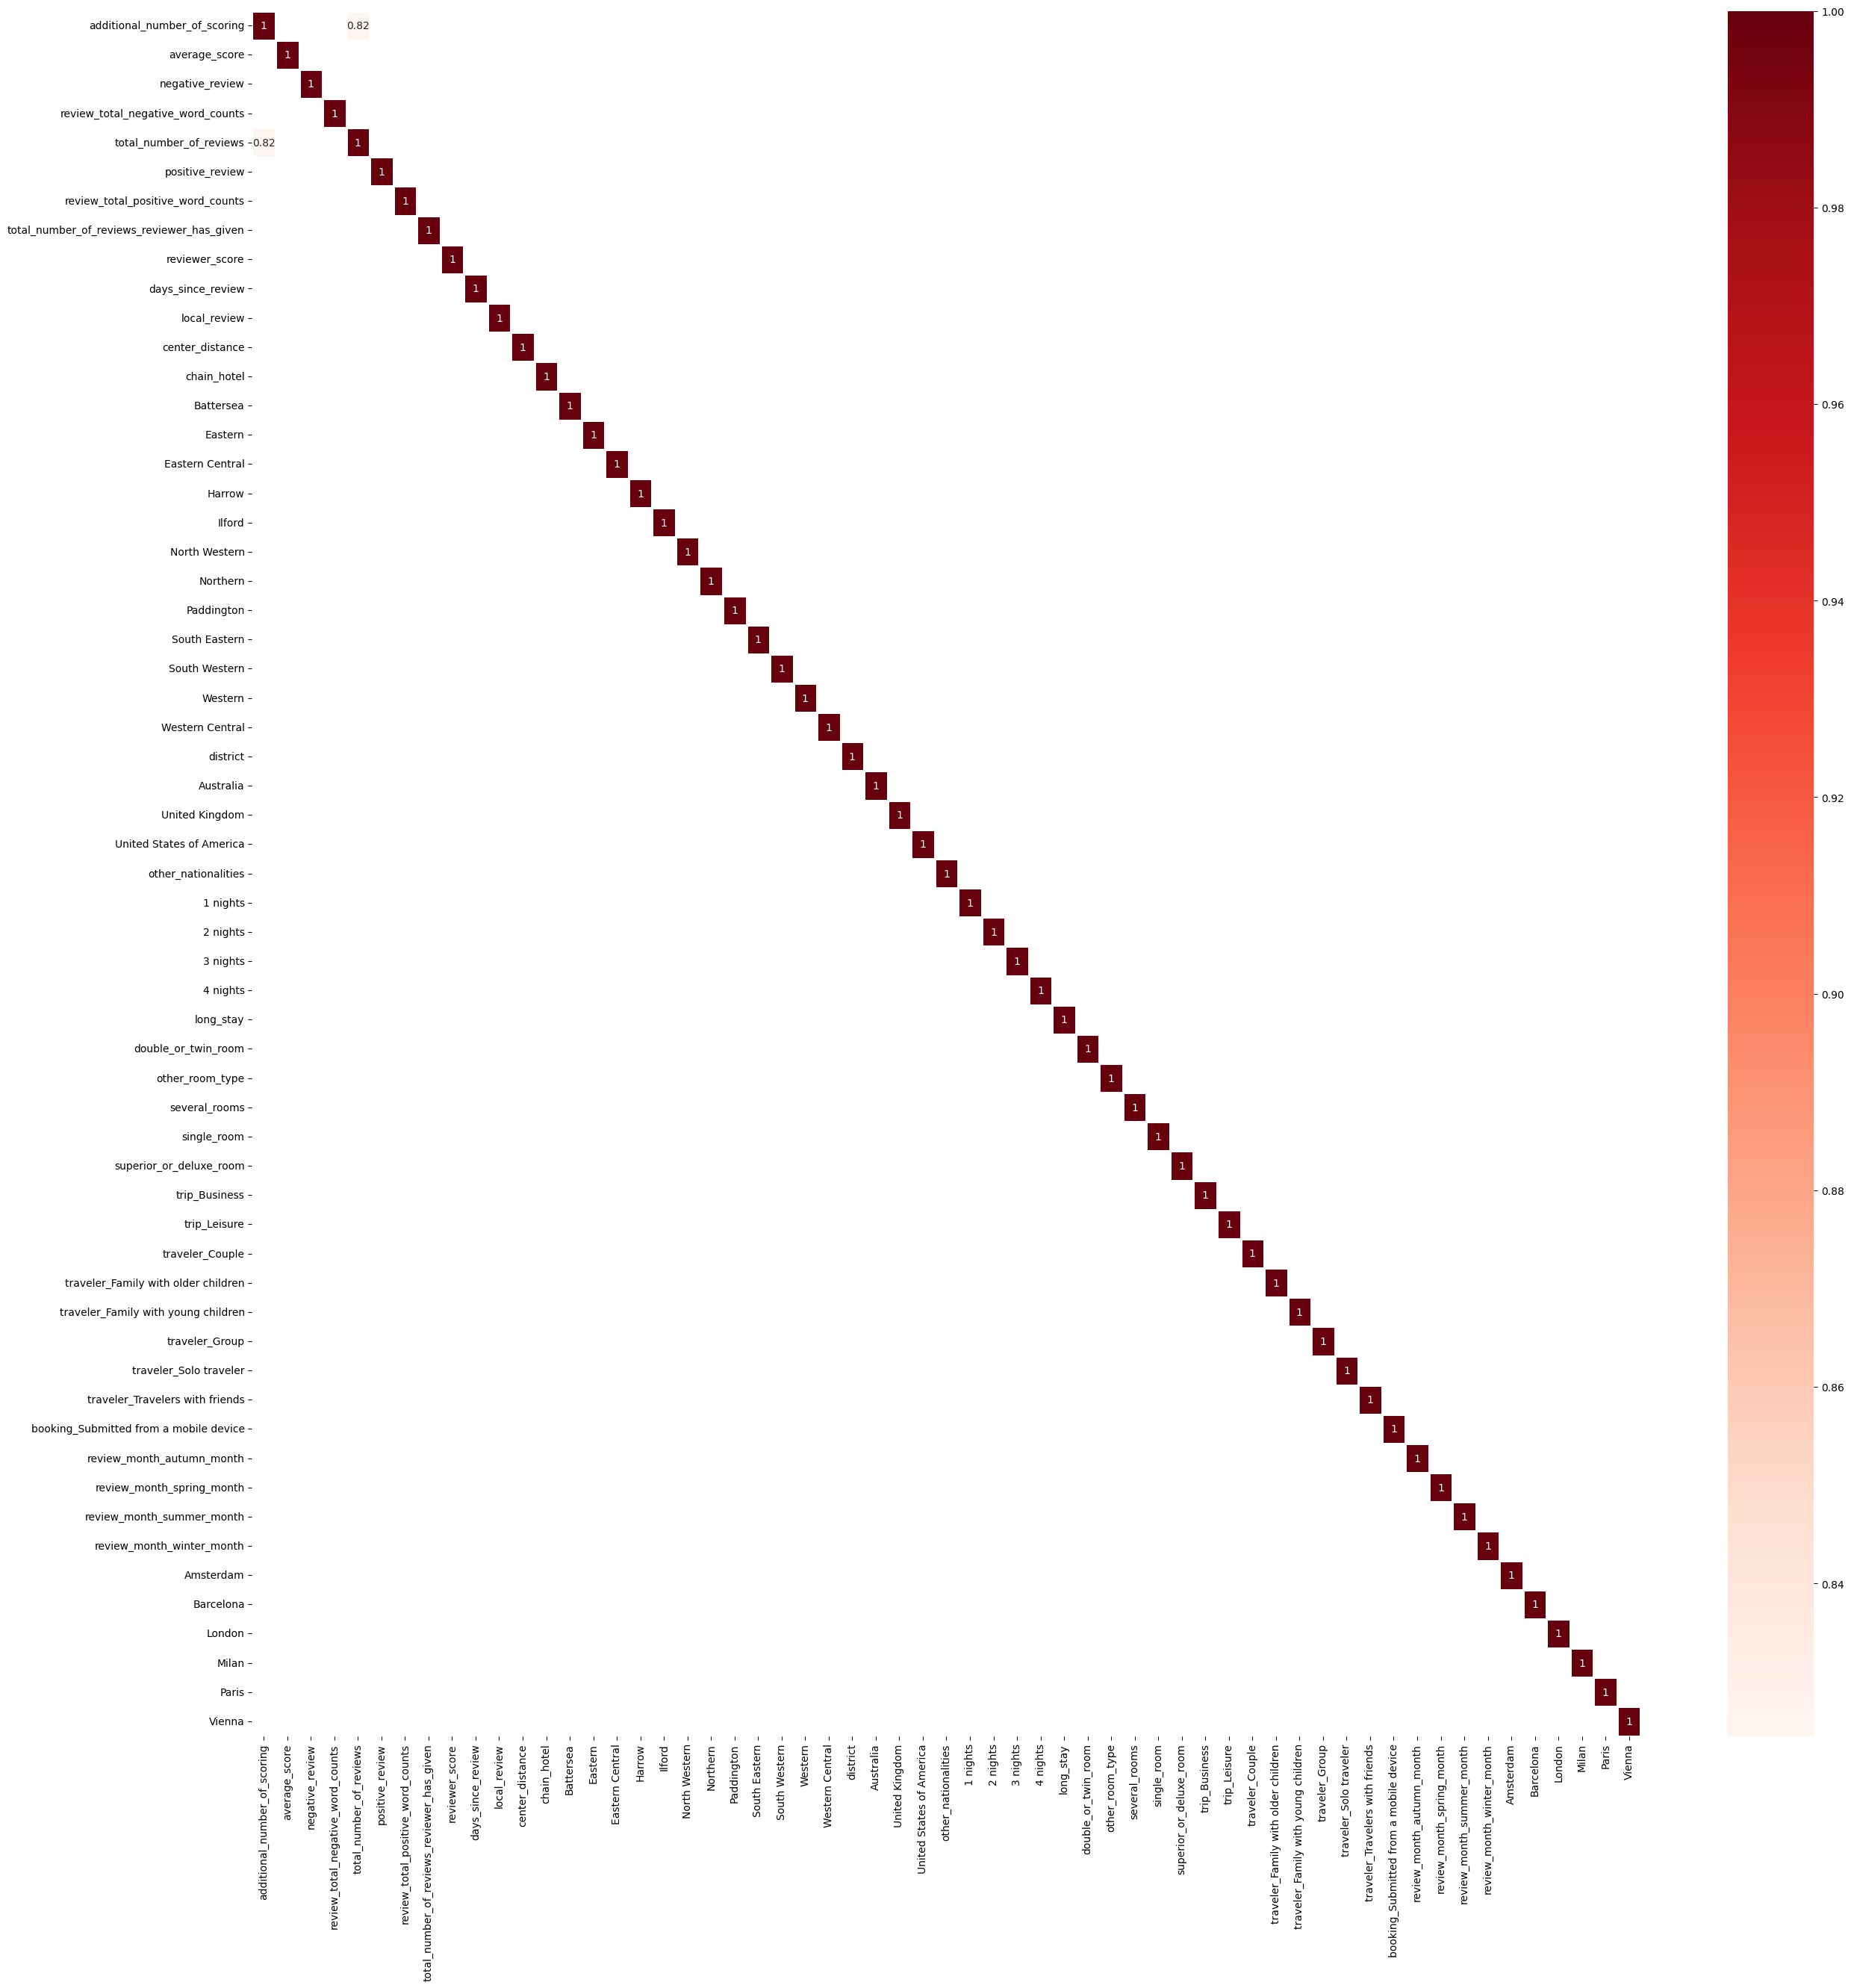

In [436]:
# создаем матрицу корреляция для полученных признаков
# мы отфильтруем нашу матрицу, чтобы она была более читаемой
corr_matrix = hotels.corr(method='pearson')
# определим 0.5 в качестве порогового значения, чтобы видеть только сильно скореллированные признаки
threshold = 0.7
# построим отфильтрованную матрицу
filtered_corr_df = corr_matrix[corr_matrix >= threshold] 
plt.figure(figsize=(30, 30))
sns.heatmap(filtered_corr_df, annot=True, cmap="Reds", linewidths=1)
plt.show()

In [437]:
# удалим признак 'additional_number_of_scoring'
hotels = hotels.drop('additional_number_of_scoring', axis=1)

In [438]:
# создадим список, содежащий интересующие числовые признаки
num_features = ['average_score',
                'review_total_negative_word_counts', 'total_number_of_reviews', 
                'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
                'days_since_review', 'center_distance'
               ]

# создадим список, содежащий интересующие категориальные признаки
cat_features = ['negative_review', 'positive_review', 'chain_hotel', 'local_review',
                'Battersea', 'Eastern', 'Eastern Central','Harrow', 'Ilford', 
                'North Western', 'Northern', 'Paddington', 'South Eastern', 'South Western',
                'Western', 'Western Central', 'district', 'Australia', 'United Kingdom',
                'United States of America', 'other_nationalities', '1 nights', '2 nights',
                '3 nights', '4 nights', 'long_stay', 'double_or_twin_room', 'other_room_type',
                'several_rooms', 'single_room', 'superior_or_deluxe_room', 'trip_Business', 
                'trip_Leisure', 'traveler_Couple', 'traveler_Family with older children',
                'traveler_Family with young children', 'traveler_Group', 'traveler_Solo traveler',
                'traveler_Travelers with friends', 'booking_Submitted from a mobile device', 
                'review_month_autumn_month', 'review_month_spring_month', 'review_month_summer_month',
                'review_month_winter_month', 'Amsterdam', 'Barcelona', 'London', 'Milan', 'Paris', 'Vienna'
               ]

<AxesSubplot: >

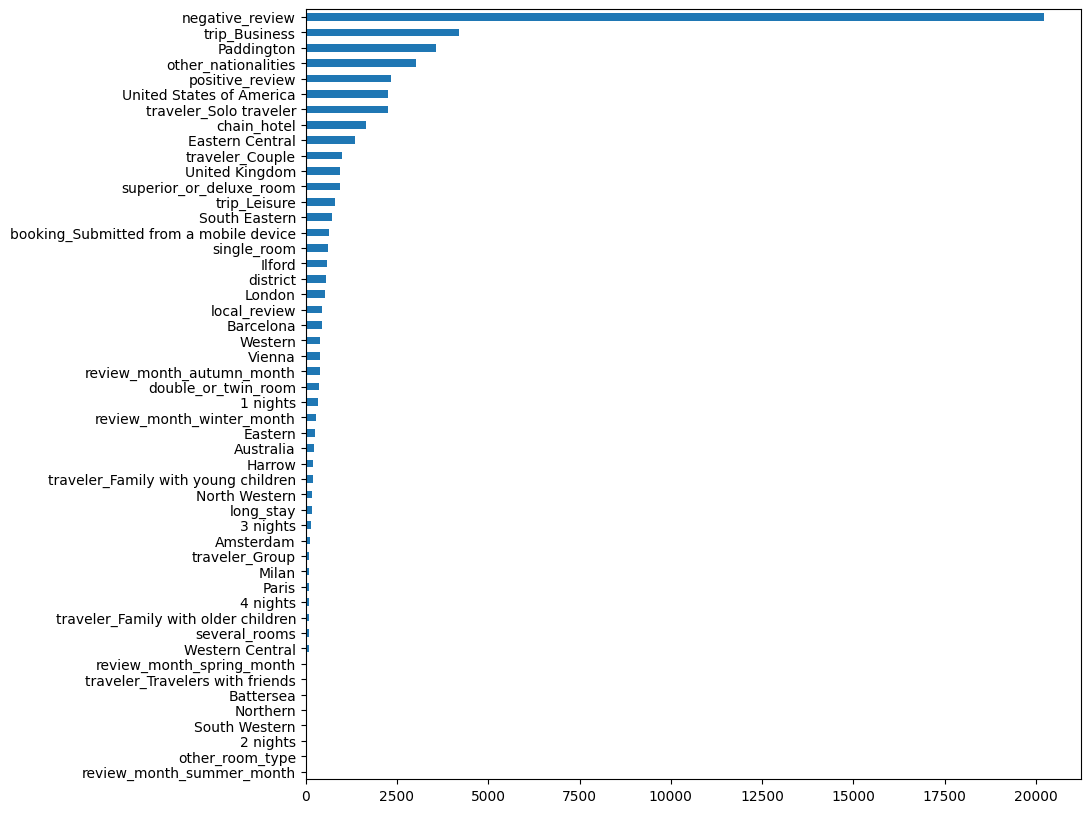

In [439]:
imp_cat = pd.Series(chi2(hotels[cat_features], hotels['reviewer_score'].astype('int'))[0], index=cat_features)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize=(10, 10))

<AxesSubplot: >

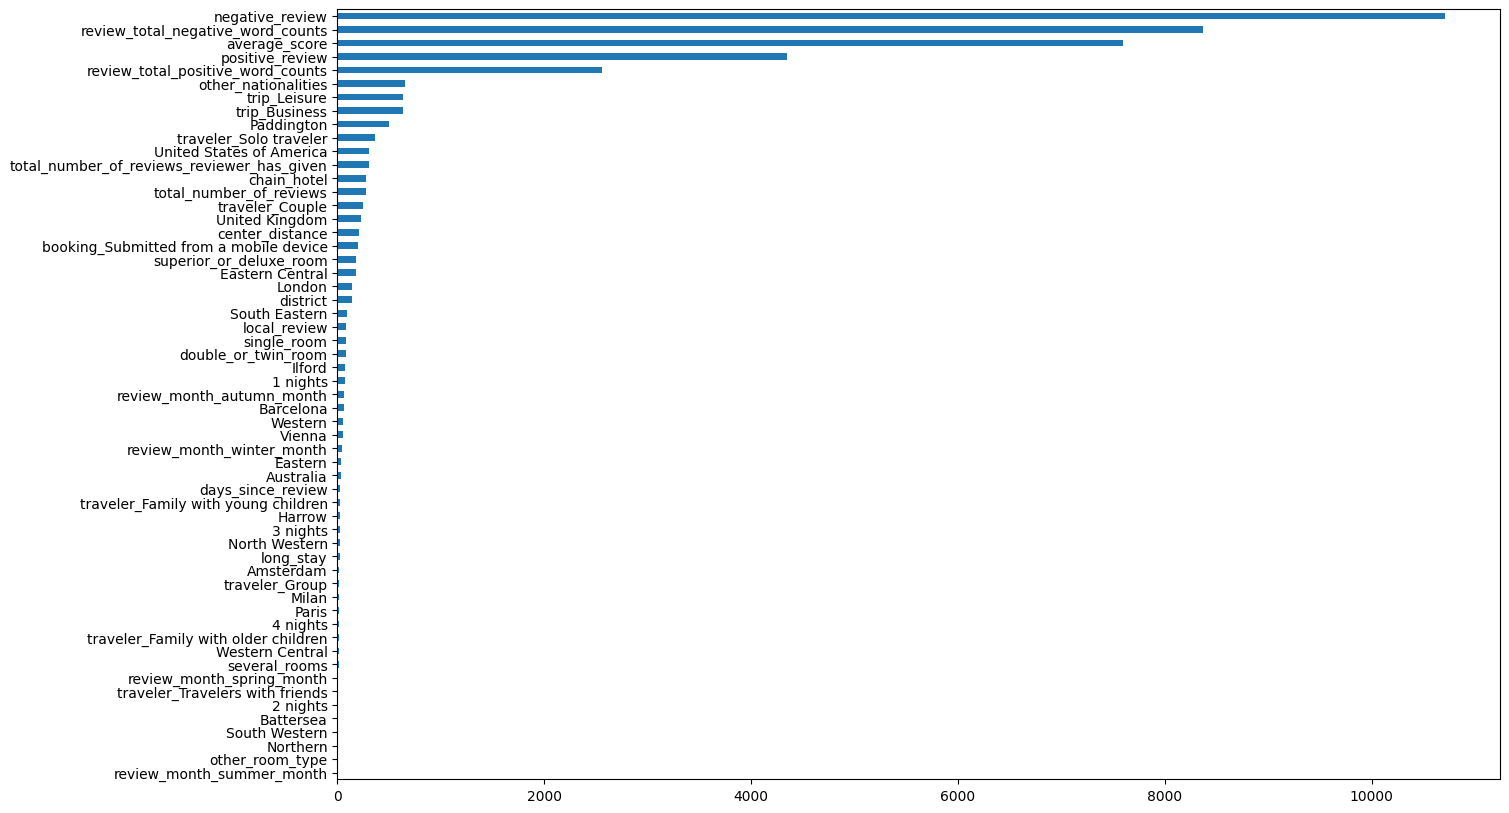

In [440]:
#graph_col = hotels.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)
graph_col = hotels.drop(['reviewer_score'], axis=1)

imp_num = pd.Series(f_classif(graph_col[graph_col.columns], hotels['reviewer_score'].astype('int'))[0], index = graph_col.columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Мы видим, что часть признаков лучше коррелируется с целевой переменной. Однако удаление слабых признаков привело к ухудшению score. По этой причине я отказался от удаления признаков.

**Нормализуем и стандартизируем признаки**

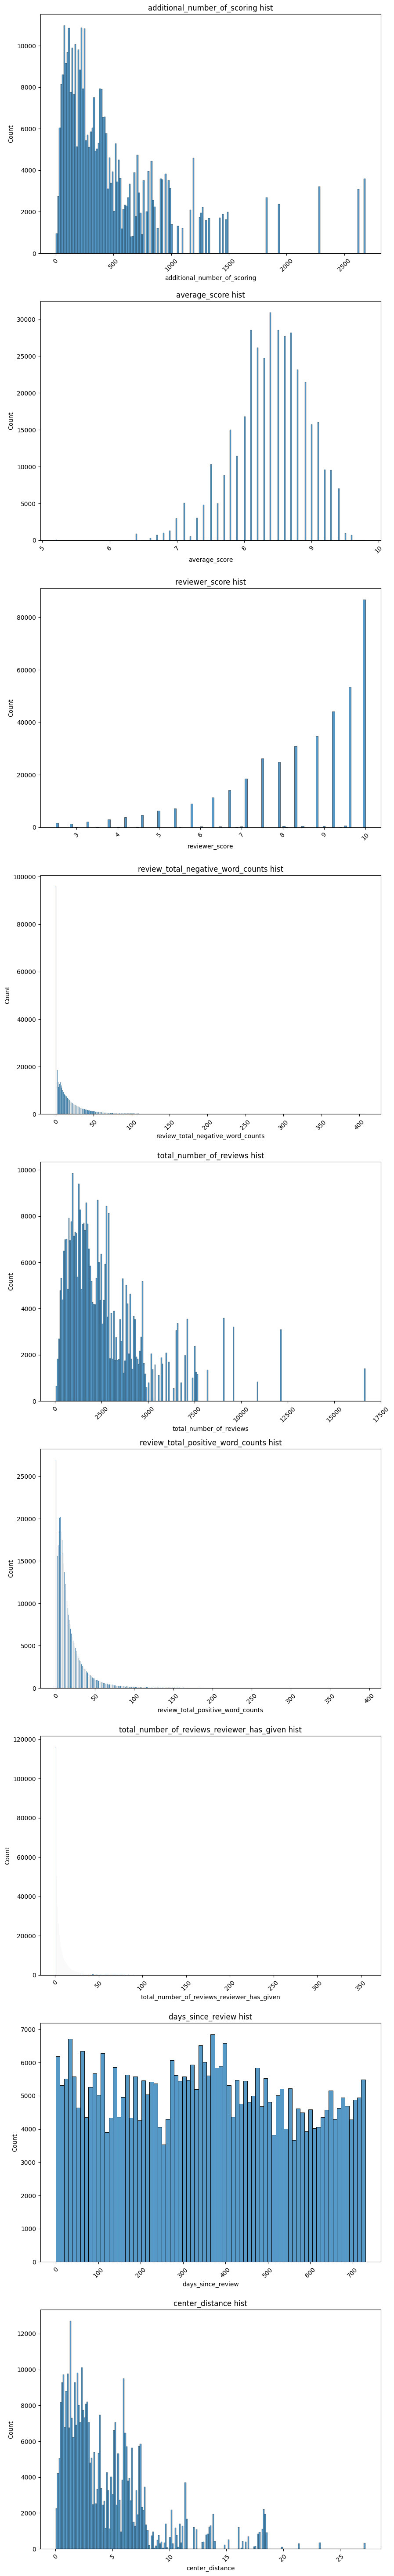

In [443]:
# создадим список, содежащий интересующие нас числовые признаки
num_features = ['additional_number_of_scoring', 'average_score', 'reviewer_score',
                'review_total_negative_word_counts', 'total_number_of_reviews', 
                'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
                'days_since_review', 'center_distance'
               ]
n = len(num_features) #количество числовых признаков

fig, axes = plt.subplots(n, figsize=(10, 75)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data, x=feature, ax=axes[i])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)

In [444]:
data[num_features].describe()

,additional_number_of_scoring,average_score,reviewer_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,center_distance
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,386803.000000
mean,498.246536,8.397231,8.396906,18.538988,2743.992042,17.776985,7.17725,354.387978,4.428977
std,500.258012,0.547881,1.636090,29.703369,2316.457018,21.726141,11.05442,208.975174,3.939944
min,1.000000,5.200000,2.500000,0.000000,43.000000,0.000000,1.00000,0.000000,0.029574
25%,169.000000,8.100000,7.500000,2.000000,1161.000000,5.000000,1.00000,175.000000,1.618990
50%,342.000000,8.400000,8.800000,9.000000,2134.000000,11.000000,3.00000,353.000000,3.150166
75%,660.000000,8.800000,9.600000,23.000000,3613.000000,22.000000,8.00000,527.000000,6.111753
max,2682.000000,9.800000,10.000000,408.000000,16670.000000,395.000000,355.00000,730.000000,27.214280


Посмотрев на распределение наших данных, на мой взгялд, можно сделать несколько выводов. Первое, признаки содержат данные, которые можно было бы принять за выбросы, но поскольку они логически нормально вписываются в наши данные (длинные отзывы, отели с большим количеством отзывов, отели, отдаленнные от центра), то удалять их будет неверно. Можно предположить, что это скорее исказит имеющиеся в нашем распоряжении данные, чем положительно скажется на качестве модели.

Второе, из гистрограмм видно, что ни один из наших признаков не имеет нормального распределения. Кроме того, числовые значения признаков сильно различаются. Так признак с общим количество обзоров исчисляется тысячами обзоров, а признак со средней оценкой находится в диапазоне между 5 и 10.

С признаком average_score мне показалось, что не все так однозначно, поскольку внешне он немного напомнил нормально распределение. Я решил дополнительно проверить его на нормальность при помощи теста Д'Агостино.

In [445]:
# проводим тест Д'Агостино для анализа распределения
# видим, что действительно признак распределн ненормально
alpha = 0.05

_, p = normaltest(data[['average_score']])
print('p=%.3f' % p[0])

if p[0] > alpha:
	print('Данные распределены нормально')
else:
	print('Данные не распределены нормально')

p=0.000
Данные не распределены нормально


Поскольку наши признаки не распределены нормально и в части признаков имеются выбросы, то теоретически данные можно было попробовать нормализировать при помощи RobustScaler. Однако подобные действия не принесли результата и модель стала работать некорректно. MinMaxScaler сильно искажает наши данные из-за имеющихся выбросов. Я попробовал стандартизация и логарифмирование данных, но в обоих случаях результат был отрицательным. Возможно, это связано с тем, что случайный лес лучше работает с необработанными данными. По этой причине я не стал трогать имеющиеся данные. 

# **Построение модели**

In [584]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score']

In [585]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [586]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [587]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 125728731370548.81


# **Краткие выводы по проекту**

По итогам нашей работы мы спроектировали несколько новых признаков из имеющихся данных, которые позволили модели отработать лучше базового решения.

В качестве выводов следует отметить, что я вижу несколько путей, которые позволят в дальнейшем улучшить построенную нами модель. 

Во-первых, мы можем более детально поработать с данными, содержащие почтовые индексы отелей. Это позволит выделить районы городов, в которых расположены отели. Возможно, что в booking или на иных сторонних ресурсах, посвященных путешествиям, можно найти рейтинг районов города. Однако эта работа требует очень много дополнительных ресурсов, связанных с поиском дополнительной информации. По этой причине я принял решение сейчас не работать в данном направлении.

Во-вторых, можно более детально проработать признаки, содержащие тексты с отзывами и тегами. Сейчас я пошел по самому простому пути поиска неких ключевых фраз, которые позволили разбить теги на отдельные признаки, а также закодировать признаки с положительными и отрицательными отзывами. При более углубленном семантическом анализе текста отзывов, мы можем попробовать их разбить на отрицательные, нейтральные и положительные. Или придумать даже более детальную систему рейтингов. При более углубленном анализе тегов можно обнаружить какие-то теги, которые были мною пропущены.

Однако требуемого результата мы достигли на текущем этапе. Полученная модель работает лучше базовой, а мы применили на практики навыки, полученные во время обучения.